In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import  ValueWarning 
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
HOURS_PER_DAY = 24
HOURS_PER_WEEK = 168 # 7 days
HOURS_PER_MONTH = 720 # 30 days
HOURS_PER_YEAR = 8760 # 365 days

In [3]:
color_pal = sns.color_palette()

In [4]:
test = pd.DataFrame(columns=["test"], index=pd.date_range(start='01-01-2021', periods=8760,freq='h'))
display(test)

,test
2021-01-01 00:00:00,NaN
2021-01-01 01:00:00,NaN
2021-01-01 02:00:00,NaN
2021-01-01 03:00:00,NaN
2021-01-01 04:00:00,NaN
...,...
2021-12-31 19:00:00,NaN
2021-12-31 20:00:00,NaN
2021-12-31 21:00:00,NaN
2021-12-31 22:00:00,NaN


In [5]:
# Load the data
df = pd.read_csv('../data/2019_2020/2020_data.csv',index_col=0)
# Generate time indexes starting on 01-01-2020 00:00:00 (hourly data)
df.index = pd.date_range(start='01-01-2021', periods=len(df), freq='h')

In [6]:
df.head(30)

,forward_RE,forward_FC,UP,DW,production_RE,production_FC,Offshore DK2,Offshore DK1,Onshore DK2,Onshore DK1
2021-01-01 00:00:00,28.32,35.395866,28.32,28.32,0.995098,1.000000,0.274701,0.506045,0.680247,0.659599
2021-01-01 01:00:00,10.07,35.127035,10.07,10.07,1.000000,1.000000,0.356135,0.541451,0.796296,0.671060
2021-01-01 02:00:00,-4.08,-3.707266,-4.08,-4.08,1.000000,0.776486,0.279045,0.219344,0.728395,0.638109
2021-01-01 03:00:00,-9.91,-17.375766,-9.91,-9.91,0.995098,0.935938,0.228013,0.201209,0.698765,0.619771
2021-01-01 04:00:00,-7.41,-7.552286,-7.41,-7.41,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011
2021-01-01 05:00:00,-12.55,-24.411927,-12.55,-12.55,0.995098,0.986932,0.221498,0.201209,0.687654,0.613754
2021-01-01 06:00:00,-17.25,-11.980539,-17.25,-17.25,0.995098,1.000000,0.221498,0.199482,0.719753,0.663897
2021-01-01 07:00:00,-15.07,-19.070846,-15.07,-15.07,0.995098,0.964787,0.228013,0.201209,0.662963,0.652722
2021-01-01 08:00:00,-4.93,-8.863565,-4.93,-4.93,1.000000,1.000000,0.386536,0.199482,0.690123,0.651003
2021-01-01 09:00:00,-6.33,-6.185262,-6.33,-6.33,1.000000,0.803111,0.386536,0.195164,0.682716,0.755874


In [7]:
df = df.drop(['forward_RE','forward_FC','UP','DW'], axis=1)

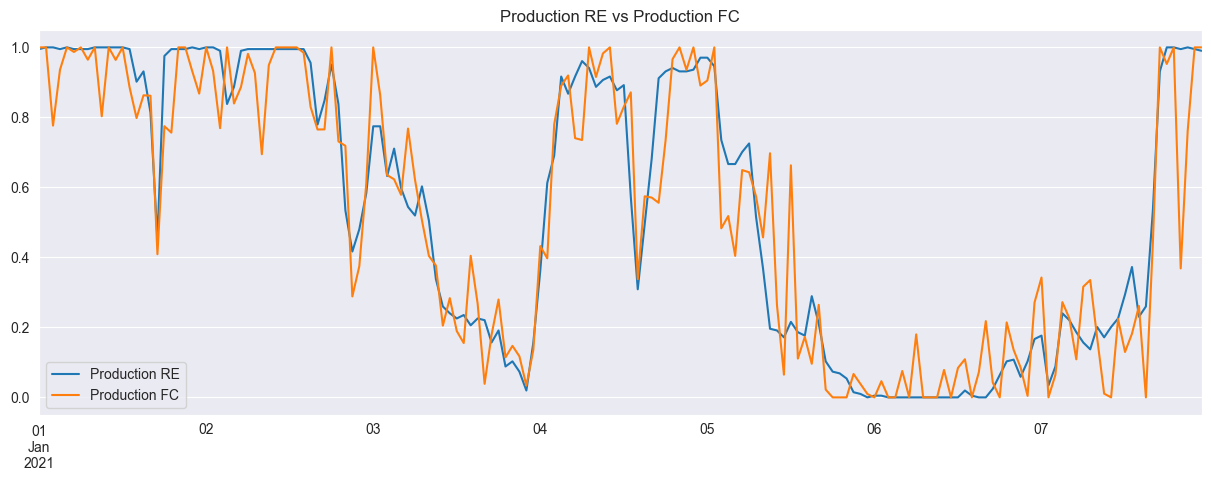

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
df['production_RE'][:HOURS_PER_WEEK].plot(ax=ax, label='Production RE')
df['production_FC'][:HOURS_PER_WEEK].plot(ax=ax, label='Production FC')
ax.set_title('Production RE vs Production FC')
ax.legend()
plt.show()

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Forecast smoothing

In [10]:
forecast = df['production_FC'].copy()

RMSE: 0.14009182893716557
RMSE: 0.10490543337248923


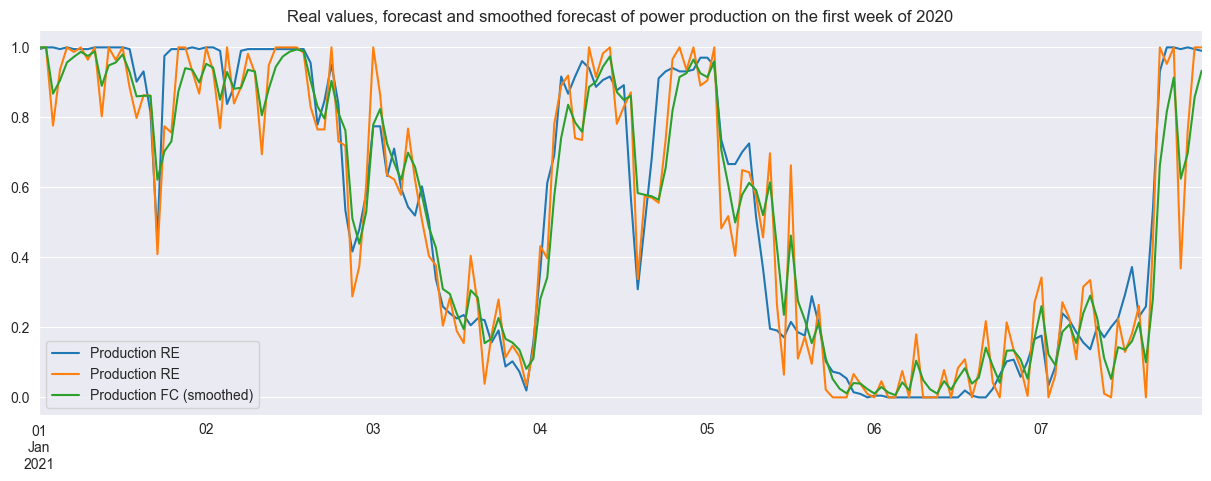

In [11]:
alpha = 0.53  # smoothing factor
forecast_smoothed = forecast.ewm(alpha=alpha).mean()


print('RMSE:', np.sqrt(mean_squared_error(df['production_RE'], forecast)))
print('RMSE:', np.sqrt(mean_squared_error(df['production_RE'], forecast_smoothed)))

fig, ax = plt.subplots(figsize=(15, 5))
df['production_RE'][:HOURS_PER_WEEK].plot(ax=ax, label='Production RE')
df['production_FC'][:HOURS_PER_WEEK].plot(ax=ax, label='Production RE')
forecast_smoothed[:HOURS_PER_WEEK].plot(ax=ax, label='Production FC (smoothed)')
ax.set_title('Real values, forecast and smoothed forecast of power production on the first week of 2020')
ax.legend()
plt.show()

In [12]:
df['production_FC'] = df['production_FC'].ewm(alpha=0.53).mean()

## Energinet data

In [13]:
df_energinet = pd.read_csv('Power_Forecasts_Hour.csv', sep=';')
df_energinet.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Power_Forecasts_Hour.csv'

In [ ]:
df_energinet.info()

In [ ]:
df_energinet = df_energinet.drop(['HourUTC','PriceArea','ForecastType','TimestampUTC','TimestampDK'], axis=1)
df_energinet.index = df_energinet['HourDK'].astype('datetime64[ns]').rename('')
df_energinet = df_energinet.drop(['HourDK'], axis=1)

df_energinet.head()

In [14]:
# Convert numbers with commas to floats
df_energinet[['ForecastDayAhead','ForecastIntraday','Forecast5Hour','Forecast1Hour','ForecastCurrent']] = df_energinet[['ForecastDayAhead','ForecastIntraday','Forecast5Hour','Forecast1Hour','ForecastCurrent']].apply(lambda x: x.str.replace(',','.')).astype(float)

df_energinet['ForecastDayAhead'] = df_energinet['ForecastDayAhead'].interpolate()
df_energinet['ForecastIntraday'] = df_energinet['ForecastIntraday'].fillna(df_energinet['ForecastDayAhead'])
df_energinet['Forecast5Hour'] = df_energinet['Forecast5Hour'].fillna(df_energinet['ForecastIntraday'])
df_energinet['Forecast1Hour'] = df_energinet['Forecast1Hour'].fillna(df_energinet['Forecast5Hour'])
df_energinet['ForecastCurrent'] = df_energinet['ForecastCurrent'].fillna(df_energinet['Forecast1Hour'])

df_energinet.head()

NameError: name 'df_energinet' is not defined

In [15]:
# Normalize the data (min-max scaling) for the forecasts
df_energinet['ForecastDayAhead'] = (df_energinet['ForecastDayAhead'] - df_energinet['ForecastDayAhead'].min()) / (df_energinet['ForecastDayAhead'].max() - df_energinet['ForecastDayAhead'].min())
df_energinet['ForecastIntraday'] = (df_energinet['ForecastIntraday'] - df_energinet['ForecastIntraday'].min()) / (df_energinet['ForecastIntraday'].max() - df_energinet['ForecastIntraday'].min())
df_energinet['Forecast5Hour'] = (df_energinet['Forecast5Hour'] - df_energinet['Forecast5Hour'].min()) / (df_energinet['Forecast5Hour'].max() - df_energinet['Forecast5Hour'].min())
df_energinet['Forecast1Hour'] = (df_energinet['Forecast1Hour'] - df_energinet['Forecast1Hour'].min()) / (df_energinet['Forecast1Hour'].max() - df_energinet['Forecast1Hour'].min())
df_energinet['ForecastCurrent'] = (df_energinet['ForecastCurrent'] - df_energinet['ForecastCurrent'].min()) / (df_energinet['ForecastCurrent'].max() - df_energinet['ForecastCurrent'].min())

NameError: name 'df_energinet' is not defined

In [16]:
# Fill the missing hours with the mean of the previous and next hour
df_energinet = df_energinet.resample('h').mean()
df_energinet = df_energinet.interpolate()

NameError: name 'df_energinet' is not defined

NameError: name 'df_energinet' is not defined

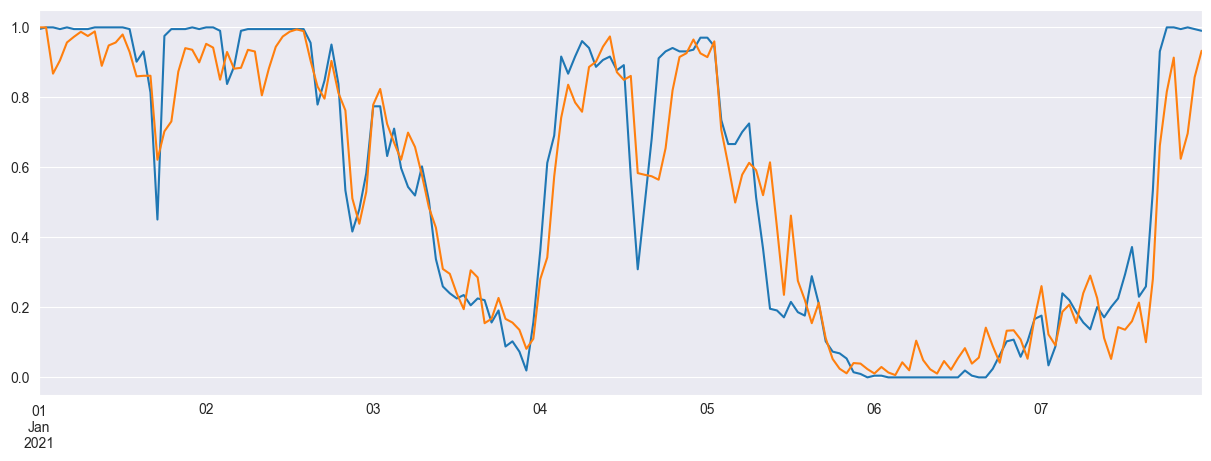

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
df['production_RE'][:HOURS_PER_WEEK].plot(ax=ax, label='Production RE')
df['production_FC'][:HOURS_PER_WEEK].plot(ax=ax, label='Production FC')
df_energinet['ForecastCurrent'][:HOURS_PER_WEEK].plot(ax=ax, label='Energinet Forecast')

ax.set_title('Production RE vs Production FC vs Energinet Forecast')
ax.legend()
plt.show()

# Short-term forecast 

In [18]:
power = df['production_RE']
da_forecasts = df['production_FC']

day_to_forecast = '04-01-2021'
training_length = 1*HOURS_PER_MONTH# 1 year of training data
test_length = 1*HOURS_PER_MONTH # 2 days of test data

train_power = power.loc[power.index < day_to_forecast]
train_power = train_power[len(train_power)-training_length:]
test_power = power.loc[power.index >= day_to_forecast][:test_length]

train_da_power = da_forecasts.ewm(alpha=0.53).mean().loc[df.index < day_to_forecast]
train_da_power = train_da_power[len(train_da_power)-training_length:]
test_da_power = da_forecasts.ewm(alpha=0.53).mean().loc[df.index >= day_to_forecast][:test_length]

# train_energinet_power = df_energinet['ForecastIntraday'].loc[df_energinet.index < day_to_forecast]
# train_energinet_power = train_energinet_power[len(train_energinet_power)-training_length:]
# test_energinet_power = df_energinet['ForecastIntraday'].loc[df_energinet.index >= day_to_forecast][:test_length]
# 
# exog_train = pd.concat([train_da_power,train_energinet_power],axis=1)
# exog_test = pd.concat([test_da_power,test_energinet_power],axis=1)

In [19]:
# Plot the forecast with the uncertainty
def plot_forecast(test_power, forecast_info,plot_title,plot_da_forecast=False):
    forecast = forecast_info.predicted_mean
    forecast[forecast < 0] = 0
    
    yhat_conf_int = forecast_info.conf_int(alpha=0.05)
    yhat_conf_int[yhat_conf_int < 0] = 0
    
    # Rename the columns
    yhat_conf_int.columns = ['lower', 'upper']
    
    yhat_conf_int_02 = forecast_info.conf_int(alpha=0.2)
    yhat_conf_int_02[yhat_conf_int_02 < 0] = 0
    
    yhat_conf_int_02.columns = ['lower', 'upper']
    
    # rmse = np.sqrt(mean_squared_error(test_power, forecast))
    # print("RMSE:", rmse)
    # 
    # map = mape(test_power, forecast)
    # print("MAPE:", map)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    test_power[:HOURS_PER_WEEK].plot(ax=ax, label='Actual')
    pd.Series(forecast, index=test_power[:HOURS_PER_WEEK].index).plot(ax=ax, label='Forecast',linestyle='--')
    ax.fill_between(test_power[:HOURS_PER_WEEK].index, yhat_conf_int['lower'][:HOURS_PER_WEEK], yhat_conf_int['upper'][:HOURS_PER_WEEK], color='orange', alpha=0.1)
    ax.fill_between(test_power[:HOURS_PER_WEEK].index, yhat_conf_int_02['lower'][:HOURS_PER_WEEK], yhat_conf_int_02['upper'][:HOURS_PER_WEEK], color='orange', alpha=0.3)
    if plot_da_forecast:
        test_da_power[:HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle='--')
    ax.set_title(plot_title)
    ax.legend()
    plt.show()

## Forecast evaluation

In [20]:
def evaluate_forecasts(forecasts, test_power):
    forecast_horizons = [1, 2, 4, 6, 12, 24]
    results = []
    
    start_time = time.time()

    rmse_dict = {horizon: [] for horizon in forecast_horizons}
    mae_dict = {horizon: [] for horizon in forecast_horizons}
    
    # Loop over the forecast times
    for i in range (len(test_power)-forecast_horizons[-1]):
        # Loop over the test data
        for horizon in forecast_horizons:
            test_power1 = test_power[i:i+horizon]
            rmse_dict[horizon].append(np.sqrt(mean_squared_error(test_power1, forecasts[i:i+horizon])))
            mae_dict[horizon].append(mean_absolute_error(test_power1, forecasts[i:i+horizon]))

    # Calculate the metrics
    mean_rmse = {horizon: np.mean(rmse_dict[horizon]) for horizon in forecast_horizons}
    mean_mae = {horizon: np.mean(mae_dict[horizon]) for horizon in forecast_horizons}

    for horizon in forecast_horizons:
        results.append([horizon, mean_rmse[horizon], mean_mae[horizon]])
    
    print('Evaluation time:', time.time() - start_time)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Hours Ahead', 'RMSE', 'MAE'])
    
    print('Test set length:', len(test_power))
    
    print('Evaluation metrics:')
    
    display(results_df)

    return results_df

def evaluate_model(train_power, model_fit, test_power, exog_test,display_model=False,display_results=True):
    forecast_horizons = [1, 2, 4, 6, 12, 24]
    results = []
    
    start_time = time.time()

    model_fit1 = model_fit
    
    if display_model:
        display(model_fit.summary())
    
    rmse_dict = {horizon: [] for horizon in forecast_horizons}
    mae_dict = {horizon: [] for horizon in forecast_horizons}
    
    for i in range (len(test_power)):
        for horizon in forecast_horizons:
            if i+horizon >= len(test_power):
                break
            test_power1 = test_power[i:i+horizon]
            exog_test1 = exog_test[i:i+horizon]
            forecast_info = model_fit1.get_forecast(steps=horizon, exog=exog_test1)
            rmse_dict[horizon].append(np.sqrt(mean_squared_error(test_power1, forecast_info.predicted_mean)))
            mae_dict[horizon].append(mean_absolute_error(test_power1, forecast_info.predicted_mean))
        model_fit1 = model_fit1.append(test_power[i:i+1],exog=exog_test[i:i+1])

        # Calculate the metrics
    mean_rmse = {horizon: np.mean(rmse_dict[horizon]) for horizon in forecast_horizons}
    mean_mae = {horizon: np.mean(mae_dict[horizon]) for horizon in forecast_horizons}

    for horizon in forecast_horizons:
        results.append([horizon, mean_rmse[horizon], mean_mae[horizon]])

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Hours Ahead', 'RMSE', 'MAE'])
       
    if display_results:
        print('Evaluation time:', time.time() - start_time)
        
        print('Train set length:', len(train_power))
    
        print('Test set length:', len(test_power))
        
        print('Evaluation metrics:')
        display(results_df)

    return results_df

def evaluate_model_period(train_power, model_fit, test_power, exog_test,period,display_model=False,display_results=True):
    forecast_horizons = [1, 2, 4, 6, 12, 24]
    results = []
    
    start_time = time.time()

    model_fit1 = model_fit
    
    if display_model:
        display(model_fit.summary())
    
    rmse_dict = {horizon: [] for horizon in forecast_horizons}
    mae_dict = {horizon: [] for horizon in forecast_horizons}
    
    for i in range (min(len(test_power),period)):
        for horizon in forecast_horizons:
            if i+horizon >= len(test_power):
                break
            test_power1 = test_power[i:i+horizon]
            exog_test1 = exog_test[i:i+horizon]
            forecast_info = model_fit1.get_forecast(steps=horizon, exog=exog_test1)
            rmse_dict[horizon].append(np.sqrt(mean_squared_error(test_power1, forecast_info.predicted_mean)))
            mae_dict[horizon].append(mean_absolute_error(test_power1, forecast_info.predicted_mean))
        if i+1 < len(test_power):
            model_fit1 = model_fit1.append(test_power[i:i+1],exog=exog_test[i:i+1])

    # Calculate the metrics
    mean_rmse = {horizon: np.mean(rmse_dict[horizon]) for horizon in forecast_horizons}
    mean_mae = {horizon: np.mean(mae_dict[horizon]) for horizon in forecast_horizons}

    for horizon in forecast_horizons:
        if len(rmse_dict[horizon]) > 0:
            results.append([horizon, mean_rmse[horizon], mean_mae[horizon]])

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Hours Ahead', 'RMSE', 'MAE'])
       
    if display_results:
        print('Evaluation time:', time.time() - start_time)
        
        print('Train set length:', len(train_power))
    
        print('Test set length:', len(test_power))
        
        print('Evaluation metrics:')
        display(results_df)

    return results_df

### Reference metrics

In [22]:
da_results = evaluate_forecasts(test_da_power, test_power)

Evaluation time: 3.028071403503418
Test set length: 720
Evaluation metrics:


,Hours Ahead,RMSE,MAE
0,1,0.092780,0.092780
1,2,0.098333,0.092854
2,4,0.103873,0.092751
3,6,0.107324,0.092767
4,12,0.112488,0.092808
5,24,0.115650,0.092228


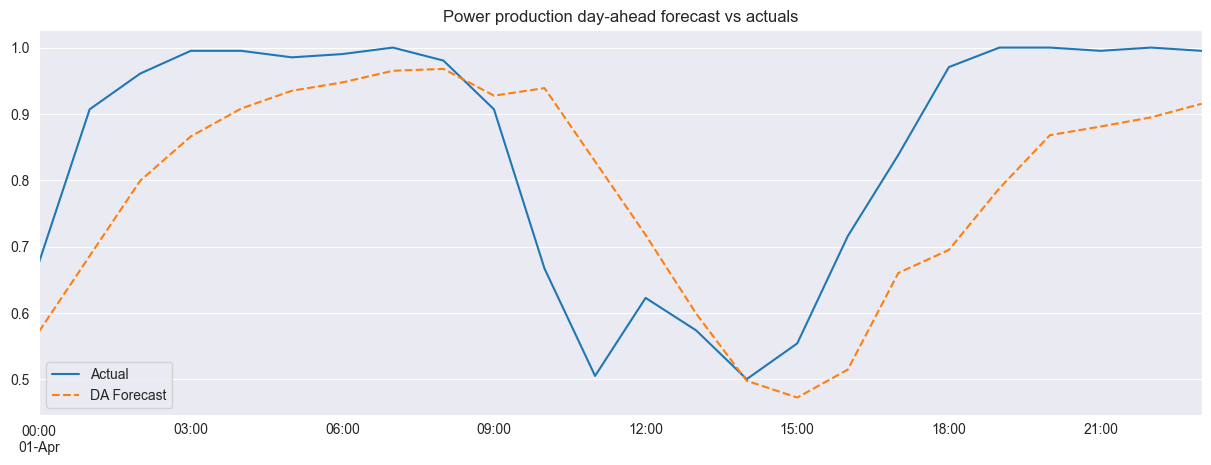

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
test_power[:HOURS_PER_DAY].plot(ax=ax, label='Actual')
test_da_power[:HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle='--')
ax.set_title('Power production day-ahead forecast vs actuals')
ax.legend()
plt.show()

## With ARIMA

### ARX

In [25]:
model = SARIMAX(train_power, order=(1,0,0),exog=train_da_power,freq='h')
model_fit = model.fit(maxiter=500)

In [26]:
results = evaluate_model(train_power, model_fit, test_power, test_da_power,display_model=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          production_RE   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 732.993
Date:                Sat, 25 May 2024   AIC                          -1459.985
Time:                        17:45:44   BIC                          -1446.248
Sample:                    03-02-2020   HQIC                         -1454.682
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
production_FC     1.0258      0.017     59.282      0.000       0.992       1.060
ar.L1             0.6967      0.019     35.780      0.000       0.659       0.735
sigma2            0.0076      0.000     32.281      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                  14.69   Jarque-Bera (JB):               523.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluation time: 21.341532707214355
Train set length: 720
Test set length: 720
Evaluation metrics:


,Hours Ahead,RMSE,MAE
0,1,0.053875,0.053875
1,2,0.069883,0.064738
2,4,0.086218,0.075631
3,6,0.094549,0.080511
4,12,0.106381,0.085964
5,24,0.113242,0.088476


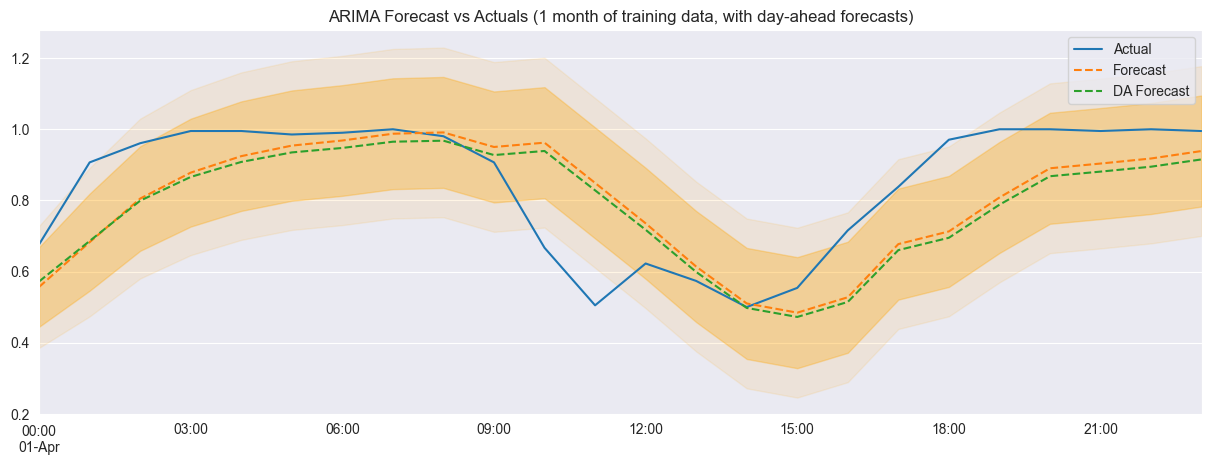

In [27]:
forecast_info = model_fit.get_forecast(steps=HOURS_PER_DAY, exog=test_da_power[:HOURS_PER_DAY])
plot_forecast(test_power[:HOURS_PER_DAY], forecast_info,"ARIMA Forecast vs Actuals (1 month of training data, with day-ahead forecasts)",plot_da_forecast=True)

In [131]:
orders = [K for K in range(0, 24)]
total_results = []
for order in orders:
    model = SARIMAX(train_power, order=(order,0,0),exog=train_da_power,freq='h')
    model_fit = model.fit(maxiter=300)
    results = evaluate_model(train_power, model_fit, test_power, test_da_power,display_model=False,display_results=False)
    results = pd.concat([pd.Series([order]*len(results), name='Order'), results], axis=1)
    total_results.append((order, results))

Evaluation time: 21.092341899871826
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 20.302006006240845
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 22.354175806045532
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 22.741676330566406
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 21.757428407669067
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 23.89621138572693
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 27.577709913253784
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 24.127211570739746
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 26.98699426651001
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation time: 26.880804777145386
Train set length: 720
Test set length: 720
Evaluation metrics:
Evaluation t

TypeError: cannot concatenate object of type '<class 'tuple'>'; only Series and DataFrame objs are valid

In [132]:
total_results = pd.concat([result[1] for result in total_results], axis=0)
total_results

,Order,Hours Ahead,RMSE,MAE
0,0,1,0.090047,0.090047
1,0,2,0.095573,0.090095
2,0,4,0.101415,0.090071
3,0,6,0.105207,0.090118
4,0,12,0.111334,0.090551
...,...,...,...,...
1,23,2,0.070923,0.065557
2,23,4,0.088453,0.077518
3,23,6,0.097193,0.082734
4,23,12,0.108886,0.088302


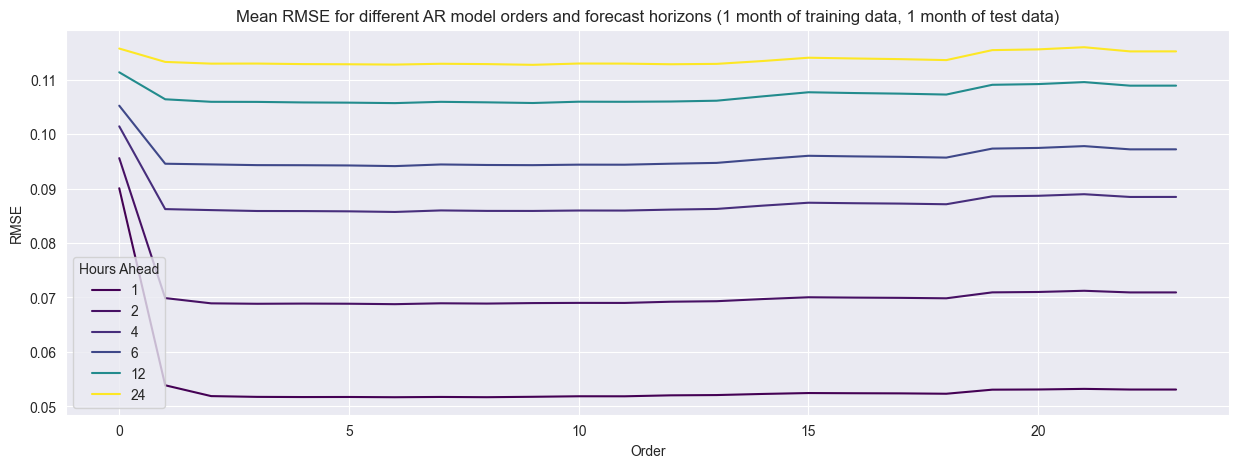

In [134]:
# For each horizon, plot the RMSE as a function of the AR model order
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=total_results, x='Order', y='RMSE', hue='Hours Ahead', palette='viridis', ax=ax)
ax.set_title('Mean RMSE for different AR model orders and forecast horizons (1 month of training data, 1 month of test data)')
plt.show()

To find the best AR model order, we compute and compre the RMSE and MAE for different AR model orders and forecast horizons.
For each forecast horizon h (between 1 and 24 hours), and for each hour t in the test set, we compute the RMSE and MAE for the forecast of the next h hours starting at t, and we average these metrics over all the hours in the test set.

In [48]:
# Do the same study as above by adding the training length as a parameter
orders = [K for K in range(0, 10)]
training_lengths = [1*HOURS_PER_DAY, 2*HOURS_PER_DAY, 1*HOURS_PER_WEEK, 2*HOURS_PER_WEEK, 1*HOURS_PER_MONTH, 3*HOURS_PER_MONTH, 6*HOURS_PER_MONTH, 1*HOURS_PER_YEAR]
total_results = []

test_power = power.loc[power.index >= day_to_forecast][:HOURS_PER_MONTH]
test_da_power = df['production_FC'].loc[df.index >= day_to_forecast][:HOURS_PER_MONTH]

for training_length in training_lengths:
    start_time = time.time()
    train_power = power.loc[power.index < day_to_forecast]
    train_power = train_power[len(train_power)-training_length:]
    
    train_da_power = df['production_FC'].loc[df.index < day_to_forecast]
    train_da_power = train_da_power[len(train_da_power)-training_length:]
    tl_results = []
    i = 0
    for order in orders:
        if 2*order > training_length:
            continue
        model = SARIMAX(train_power, order=(order,0,0),exog=train_da_power,freq='h')
        model_fit = model.fit(maxiter=300)
        results = evaluate_model(train_power, model_fit, test_power, test_da_power,display_model=False,display_results=False)
        results = pd.concat([pd.Series([order]*len(results), name='Order'), results], axis=1)
        results.index = results.index + i
        tl_results.append(results)
        i += len(results)
    results = pd.concat([pd.Series([training_length]*len(tl_results), name='Training length'), pd.concat(tl_results, axis=0)], axis=1)
    print('Training length:', training_length, 'done in', time.time() - start_time)
    total_results.append(results)
    
total_results = pd.concat(total_results, axis=0)

Evaluation time: 16.93070387840271
Evaluation time: 16.602396965026855
Evaluation time: 17.039562702178955
Evaluation time: 17.33835530281067
Evaluation time: 17.26483416557312
Evaluation time: 17.743176698684692
Evaluation time: 17.966734647750854
Evaluation time: 18.8044536113739
Evaluation time: 18.58814287185669
Evaluation time: 18.801771640777588
Training length: 24 done in 178.82247877120972
Evaluation time: 16.632474422454834
Evaluation time: 16.926441192626953
Evaluation time: 17.152359008789062
Evaluation time: 21.40861487388611
Evaluation time: 22.214329957962036
Evaluation time: 18.198899745941162
Evaluation time: 17.985328197479248
Evaluation time: 17.82036280632019
Evaluation time: 17.797041177749634
Evaluation time: 27.911311388015747
Training length: 48 done in 195.75047492980957
Evaluation time: 18.997033834457397
Evaluation time: 23.107389211654663
Evaluation time: 26.43391704559326
Evaluation time: 27.607215881347656
Evaluation time: 27.235931873321533
Evaluation time

In [53]:
total_results.head(1000)

,Training length,Order,Hours Ahead,RMSE,MAE
0,24.0,0,1,0.077350,0.077350
1,24.0,0,2,0.084133,0.077335
2,24.0,0,4,0.090048,0.077279
3,24.0,0,6,0.093054,0.077292
4,24.0,0,12,0.097358,0.077519
...,...,...,...,...,...
475,NaN,9,2,0.070837,0.065422
476,NaN,9,4,0.091885,0.081276
477,NaN,9,6,0.106227,0.092789
478,NaN,9,12,0.132713,0.113752


In [62]:
total_results.index = [i for i in range(len(total_results))]
training_lengths = [1*HOURS_PER_DAY, 2*HOURS_PER_DAY, 1*HOURS_PER_WEEK, 2*HOURS_PER_WEEK, 1*HOURS_PER_MONTH, 3*HOURS_PER_MONTH, 6*HOURS_PER_MONTH, 1*HOURS_PER_YEAR]
total_results['Training length'] = [str(training_length) for training_length in training_lengths for _ in range(60)]

,Training length,Order,Hours Ahead,RMSE,MAE
0,24,0,1,0.077350,0.077350
1,24,0,2,0.084133,0.077335
2,24,0,4,0.090048,0.077279
3,24,0,6,0.093054,0.077292
4,24,0,12,0.097358,0.077519
...,...,...,...,...,...
475,8760,9,2,0.070837,0.065422
476,8760,9,4,0.091885,0.081276
477,8760,9,6,0.106227,0.092789
478,8760,9,12,0.132713,0.113752


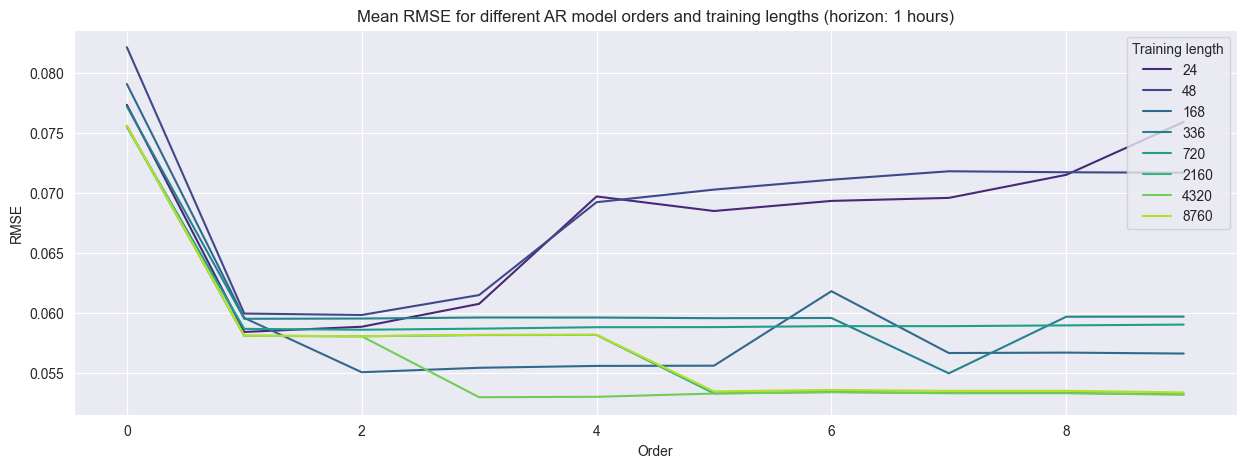

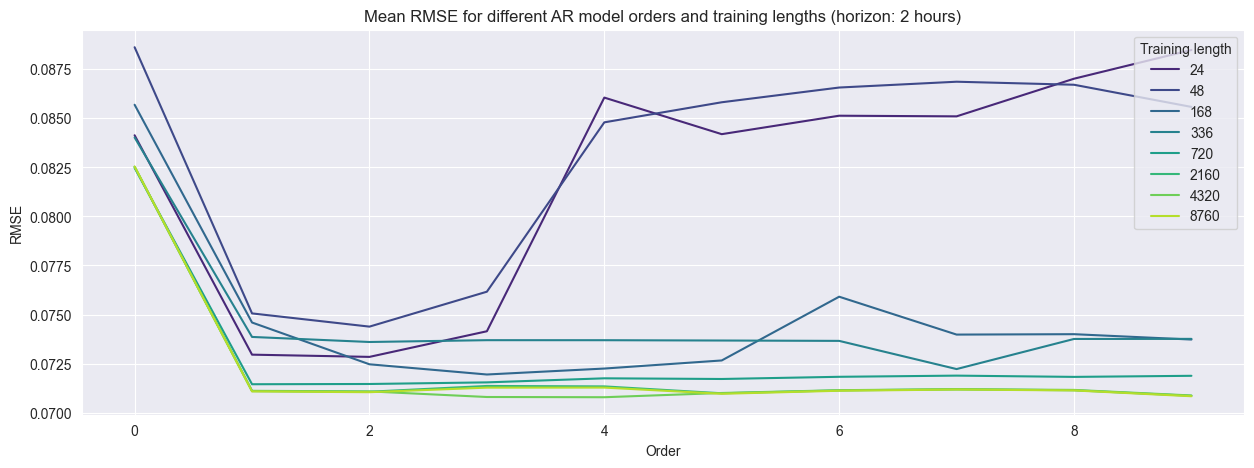

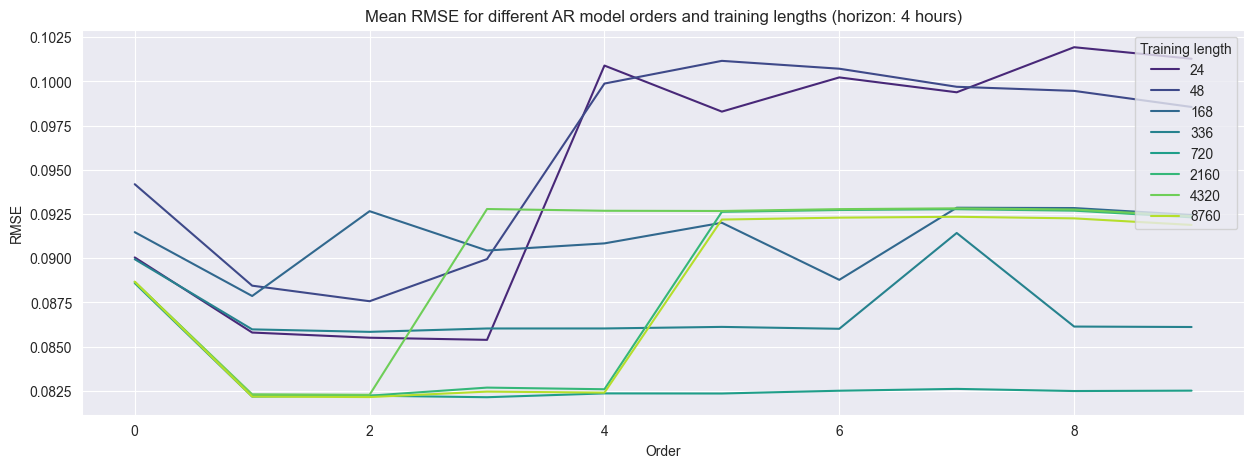

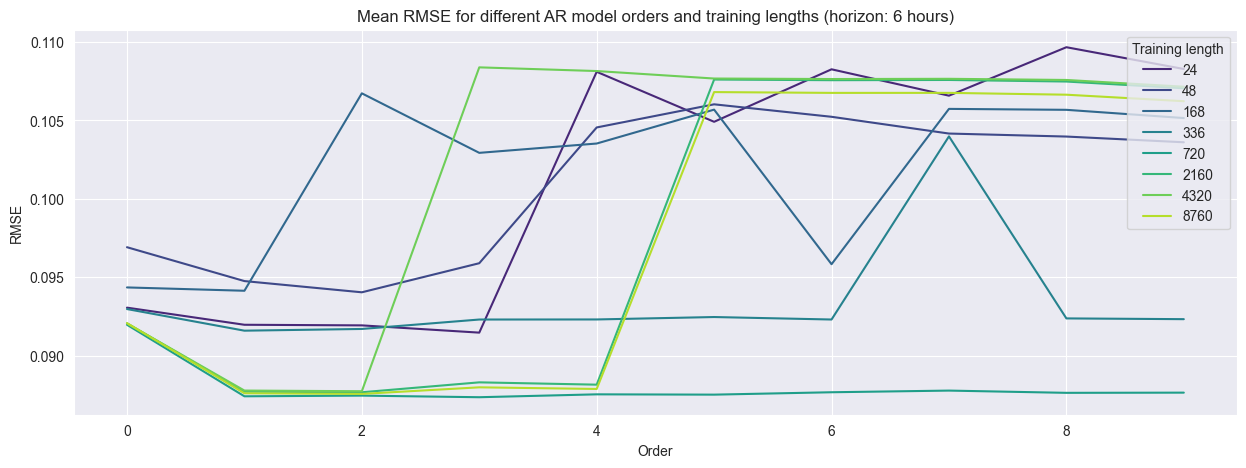

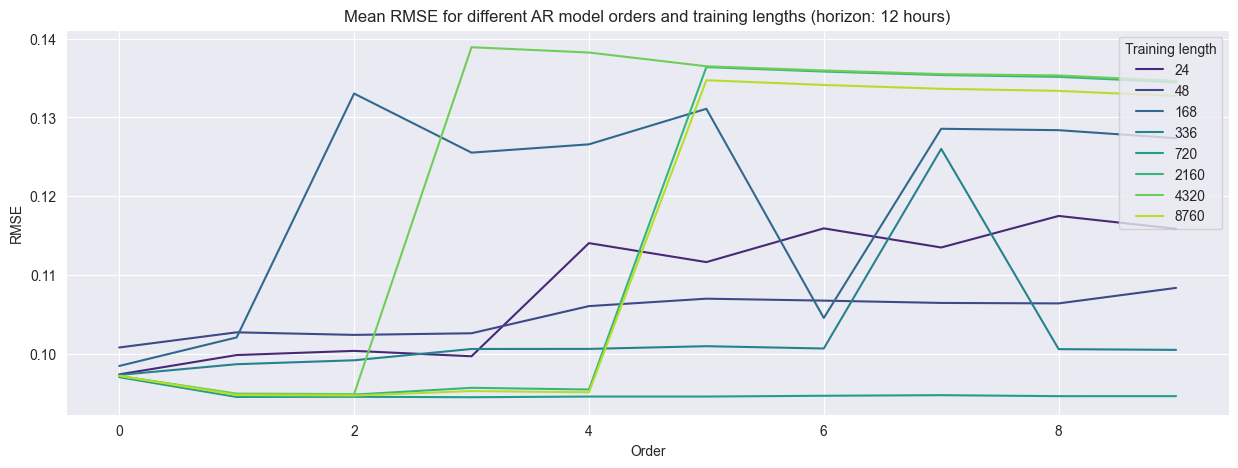

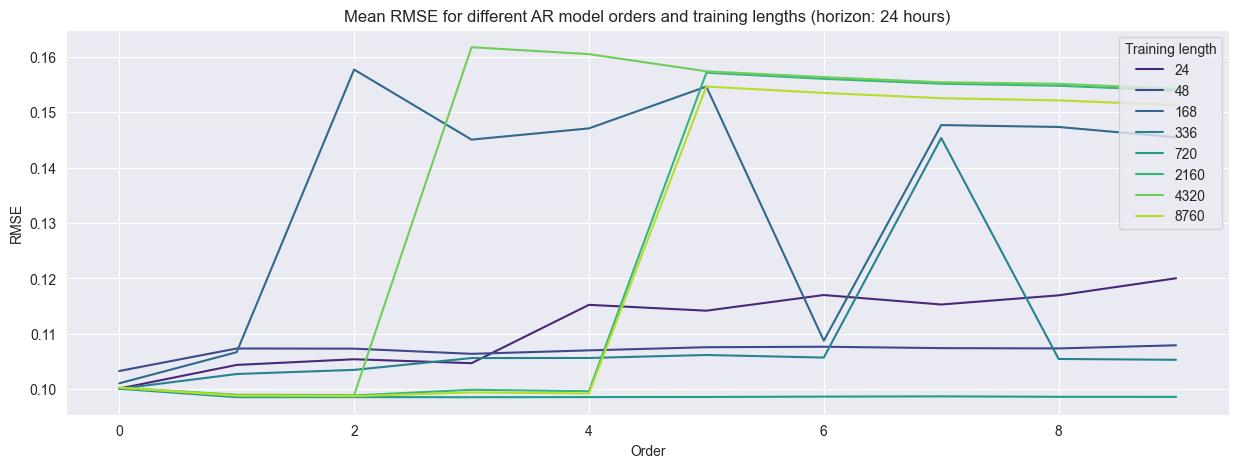

In [69]:
# Plot for each horizon the RMSE and MAE as a function of order with training length as hue
for horizon in [1, 2, 4, 6, 12, 24]:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(data=total_results[total_results['Hours Ahead'] == horizon], x='Order', y='RMSE', hue='Training length', palette='viridis', ax=ax)
    ax.set_title(f'Mean RMSE for different AR model orders and training lengths (horizon: {horizon} hours)')
    ax.legend(title='Training length', loc='upper right')
plt.show()

This shows that the best AR model order is 3 (or 2) for a training length of 1 month. There is still an improvement in the forecast quality compared to using only the day-ahead forecast, particularly for shorter horizons.

TODO: compare the forecast quality for different forecast horizons when not retraining the model, retraining the model every week, every day and every hour.

In [46]:
retraining_freqs = [1*HOURS_PER_MONTH,1*HOURS_PER_WEEK, 1*HOURS_PER_DAY, 1]
order = 3
total_results = []

test_power = power.loc[power.index >= day_to_forecast][:HOURS_PER_MONTH]
test_da_power = df['production_FC'].loc[df.index >= day_to_forecast][:HOURS_PER_MONTH]

train_power = power.loc[power.index < day_to_forecast]
train_power = train_power[len(train_power)-1*HOURS_PER_MONTH:]
train_da_power = df['production_FC'].loc[df.index < day_to_forecast]
train_da_power = train_da_power[len(train_da_power)-1*HOURS_PER_MONTH:]

test_power = power.loc[power.index >= day_to_forecast][:HOURS_PER_MONTH]
test_da_power = df['production_FC'].loc[df.index >= day_to_forecast][:HOURS_PER_MONTH]

for retraining_freq in retraining_freqs:
    start_time = time.time()
    tl_results = []
    i = 0
    train_power1 = train_power
    train_da_power1 = train_da_power
    for j in range(0, len(test_power), retraining_freq):
        model = SARIMAX(train_power1, order=(order,0,0),exog=train_da_power1,freq='h')
        model_fit = model.fit(maxiter=300)
        print(len(test_power[j:]))
        results = evaluate_model_period(train_power1, model_fit, test_power[j:], test_da_power[j:],period=retraining_freq,
        display_model=False,display_results=False)
        results.index = results.index + i
        tl_results.append(results)
        i += len(results)
        train_power1 = pd.concat([train_power1, test_power[j:j+retraining_freq]])[retraining_freq:]
        train_da_power1 = pd.concat([train_da_power1, test_da_power[j:j+retraining_freq]])[retraining_freq:]
    results = pd.concat(tl_results, axis=0)
    # Make the mean of RMSE and MAE for each horizon
    mean_rmse = results.groupby(['Hours Ahead'])['RMSE'].mean().reset_index()
    mean_mae = results.groupby(['Hours Ahead'])['MAE'].mean().reset_index()
    results = pd.merge(mean_rmse, mean_mae, on=['Hours Ahead'])
    results = pd.concat([pd.Series([retraining_freq]*len(results), name='Retraining frequency'), results], axis=1)
    display(results)
    print('Retraining frequency:', retraining_freq, 'done in', time.time() - start_time)
    total_results.append(results)

total_results = pd.concat(total_results, axis=0)
display(total_results)

720


,Retraining frequency,Hours Ahead,RMSE,MAE
0,720,1,0.058690,0.058690
1,720,2,0.071543,0.064861
2,720,4,0.082143,0.069754
3,720,6,0.087338,0.071708
4,720,12,0.094459,0.074092
5,720,24,0.098533,0.075281


Retraining frequency: 720 done in 21.458121299743652
720
552
384
216
48


,Retraining frequency,Hours Ahead,RMSE,MAE
0,168,1,0.054215,0.054215
1,168,2,0.070487,0.064662
2,168,4,0.089985,0.078552
3,168,6,0.103564,0.088518
4,168,12,0.131584,0.109360
5,168,24,0.164164,0.134548


Retraining frequency: 168 done in 22.712409019470215
720
696
672
648
624
600
576
552
528
504
480
456
432
408
384
360
336
312
288
264
240
216
192
168
144
120
96
72
48
24


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Retraining frequency,Hours Ahead,RMSE,MAE
0,24,1,0.055475,0.055475
1,24,2,0.071666,0.065807
2,24,4,0.090416,0.079044
3,24,6,0.103131,0.088365
4,24,12,0.127480,0.106638
5,24,24,0.144798,0.118563


Retraining frequency: 24 done in 30.005744457244873
720
719
718
717
716
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658
657
656
655
654
653
652
651
650
649
648
647
646
645
644
643
642
641
640
639
638
637
636
635
634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


23


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


22


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


21


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


20


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


17


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


10


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


6


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\mathi\AppData\Local\Temp\ipykernel_16216\475303909.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(tl_results, axis=0)


,Retraining frequency,Hours Ahead,RMSE,MAE
0,1,1,0.055362,0.055362
1,1,2,0.071437,0.065632
2,1,4,0.090201,0.078831
3,1,6,0.102814,0.088054
4,1,12,0.126478,0.105535
5,1,24,0.144599,0.118364


Retraining frequency: 1 done in 232.14965295791626


,Retraining frequency,Hours Ahead,RMSE,MAE
0,720,1,0.058690,0.058690
1,720,2,0.071543,0.064861
2,720,4,0.082143,0.069754
3,720,6,0.087338,0.071708
4,720,12,0.094459,0.074092
5,720,24,0.098533,0.075281
0,168,1,0.054215,0.054215
1,168,2,0.070487,0.064662
2,168,4,0.089985,0.078552
3,168,6,0.103564,0.088518


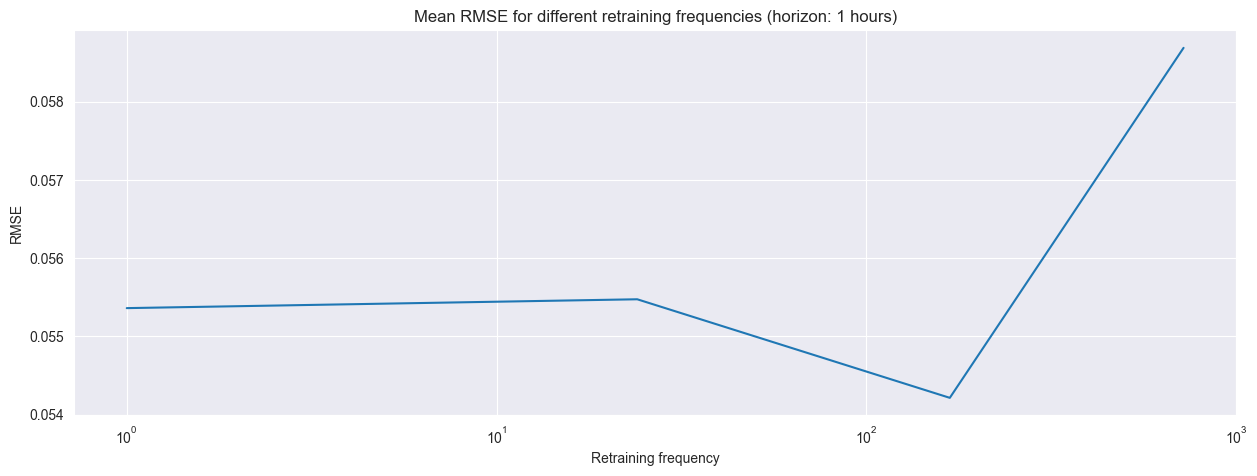

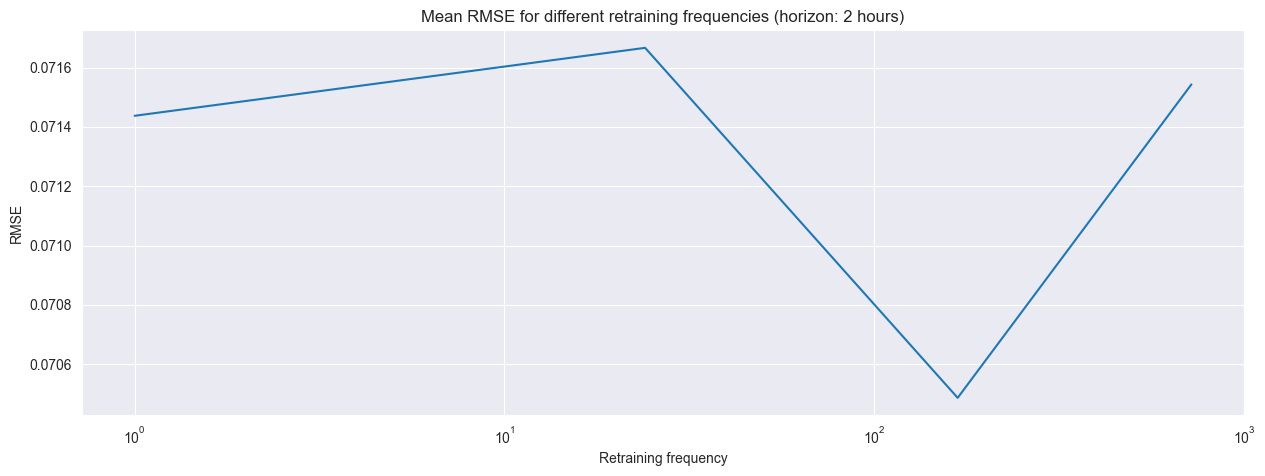

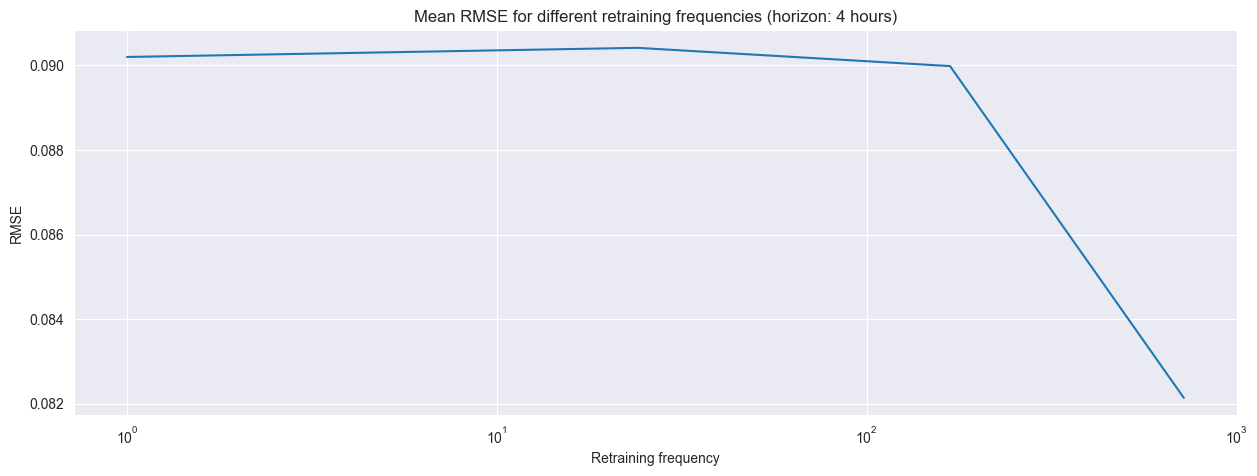

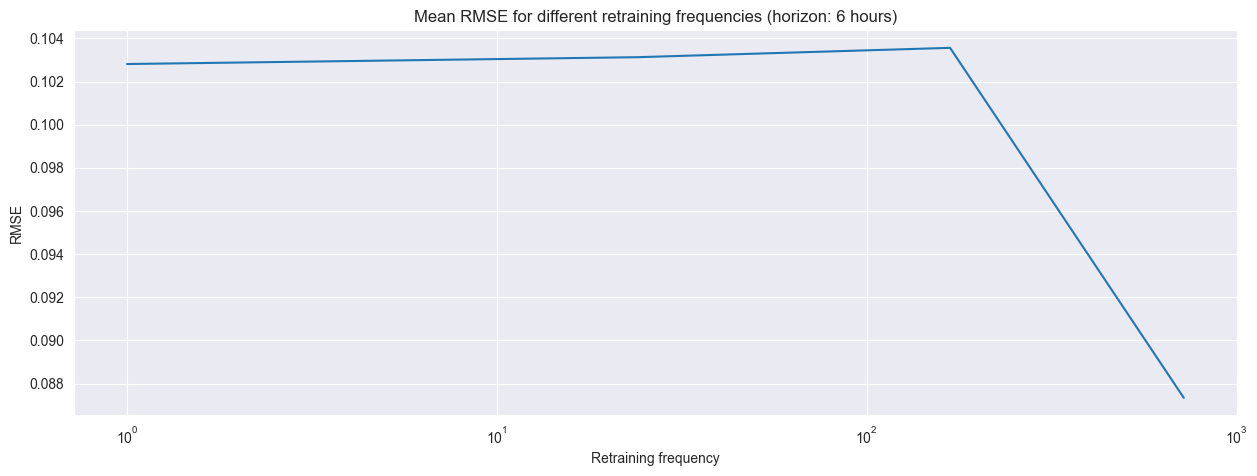

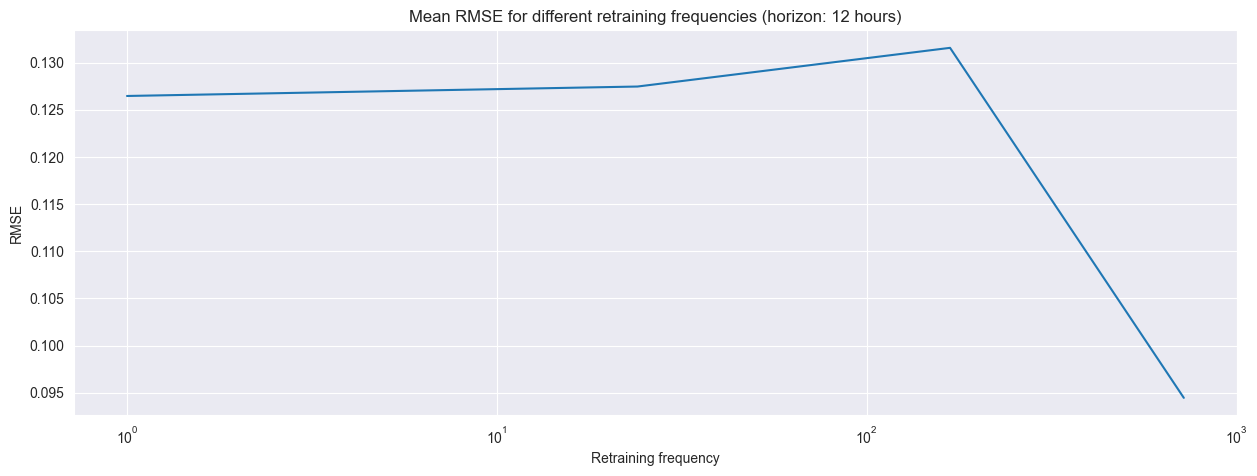

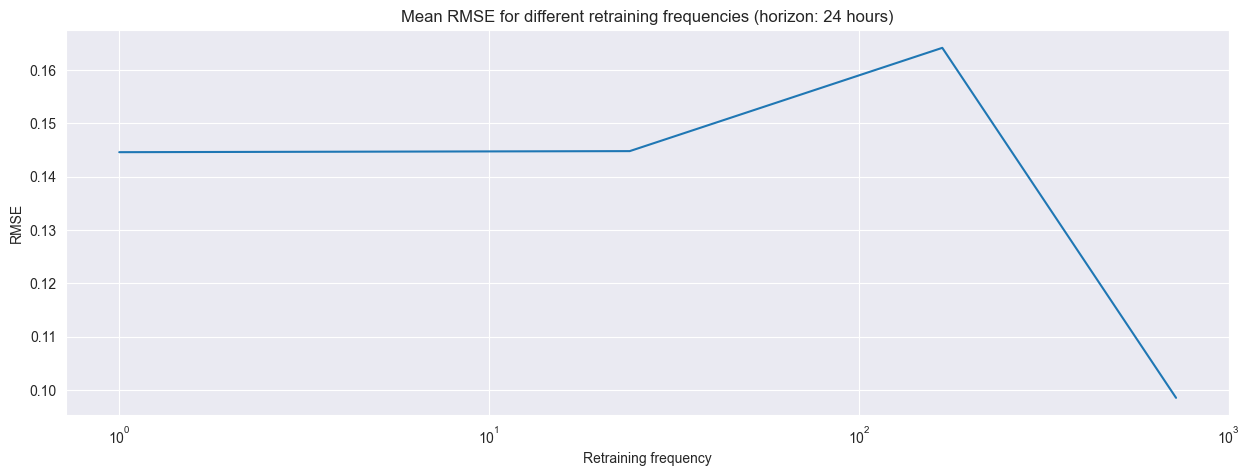

In [47]:
# Plot for each horizon the RMSE and MAE as a function of the retraining frequency
for horizon in [1, 2, 4, 6, 12, 24]:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(data=total_results[total_results['Hours Ahead'] == horizon], x='Retraining frequency', y='RMSE', palette='viridis', ax=ax)
    ax.set_title(f'Mean RMSE for different retraining frequencies (horizon: {horizon} hours)')
    ax.set_xscale('log')
plt.show()

These evaluations show that retraining the model every day or every week does not improve the forecast quality compared to retraining the model every month. 

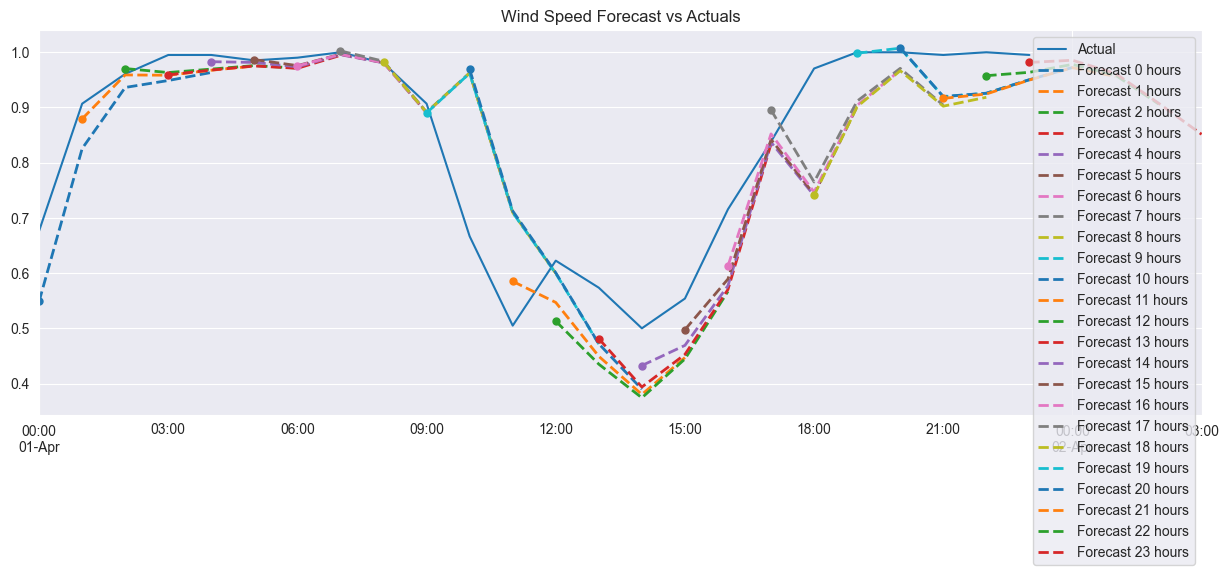

In [459]:
colors = sns.color_palette(n_colors=len(forecasts))

# Plot the first forecast
fig, ax = plt.subplots(figsize=(15, 5))
test_power[:HOURS_PER_DAY].plot(ax=ax, label='Actual')
for i, forecast in enumerate(forecasts[:24]):
    pd.Series(forecast[:5]).plot(ax=ax, label=f'Forecast {i} hours',linestyle='--',linewidth=2,color=colors[i])
    # Add a dot for the first hour forecast
    pd.Series(forecast.iloc[0], index=[forecast.index[0]]).plot(ax=ax, marker='o', markersize=5, color=colors[i])
ax.set_title('Wind Speed Forecast vs Actuals')
ax.legend()
plt.show()

Plot to see the influence of AR model order and training length on the forecast quality (MSE on 24 hours forecast).

https://www.researchgate.net/publication/245289638_Short-Term_Wind_Power_Forecast_Based_on_ARX_Models

In [63]:
# Do the same study as above, but with a rolling forecast (forecast the next 24 hours, then add only the next hour to the training set and forecast the next 24 hours, and so on)
def rolling_forecast(training_length, day_to_forecast, order=(1,0,0)):
    rmse = []
    forecasts = []
    train_power = power.loc[power.index < day_to_forecast]
    test_power = power.loc[power.index >= day_to_forecast]
    train_da_power = df['production_FC'].loc[df.index < day_to_forecast]
    test_da_power = df['production_FC'].loc[df.index >= day_to_forecast]
    for i in range(HOURS_PER_WEEK):
        train_power = train_power[len(train_power)-training_length:]
        train_da_power = train_da_power[len(train_da_power)-training_length:]
        model = SARIMAX(train_power, order=order,freq='h',exog=train_da_power)
        model_fit = model.fit(maxiter=300)
        forecast = model_fit.get_forecast(steps=HOURS_PER_DAY,exog=test_da_power[i:i+HOURS_PER_DAY])
        rmse.append(np.sqrt(mean_squared_error(test_power[i:i+HOURS_PER_DAY], forecast.predicted_mean)))
        forecasts.append(forecast)
        train_power = pd.concat([train_power, pd.Series(test_power.iloc[i],index=[test_power.index[i]])])
        train_da_power = pd.concat([train_da_power, pd.Series(test_da_power.iloc[i],index=[test_da_power.index[i]])])
    return rmse, forecasts

In [64]:
rmse, forecasts = rolling_forecast(1*HOURS_PER_DAY, '04-01-2020', order=(3,0,0))

Mean RMSE:  0.15503095485215973


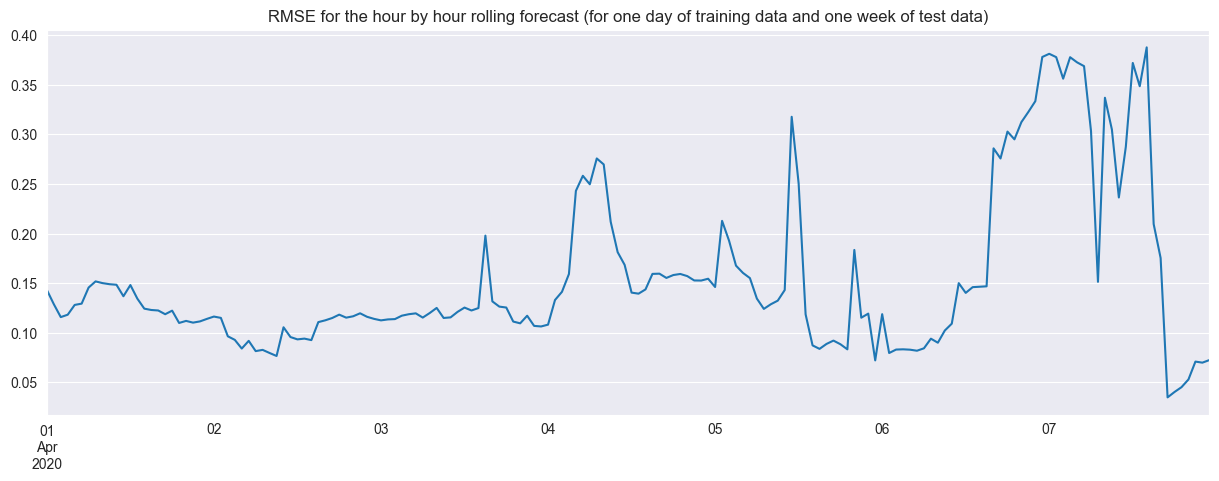

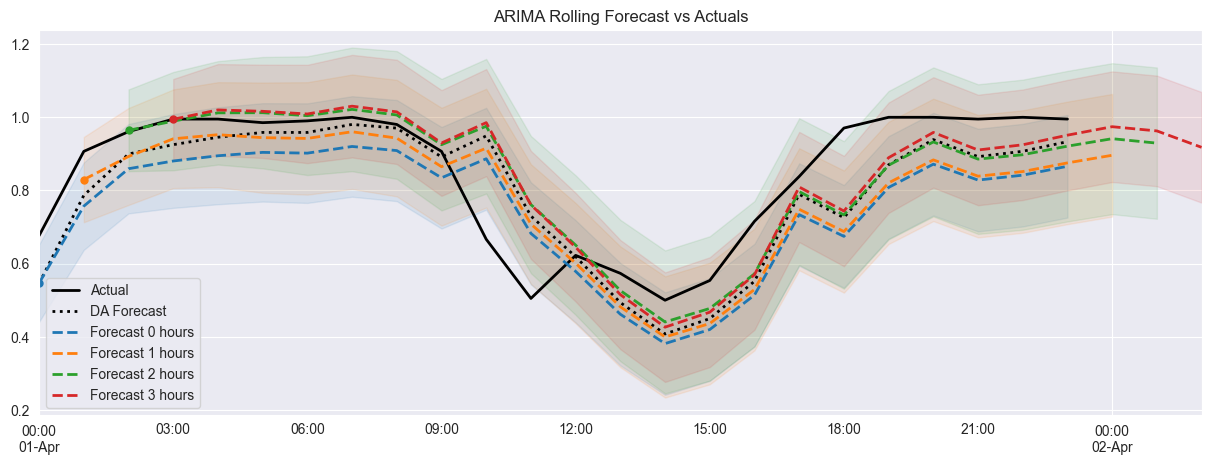

In [69]:
#Print the mean RMSE for the rolling forecast
print('Mean RMSE: ', np.mean(rmse))

test_power = power.loc[power.index >= day_to_forecast]

first_hour_forecast = pd.Series([forecast.predicted_mean.iloc[0] for forecast in forecasts], index=test_power[:HOURS_PER_WEEK].index)
first_hour_upper = pd.Series([forecast.conf_int().iloc[0,1] for forecast in forecasts], index=test_power[:HOURS_PER_WEEK].index)
first_hour_lower = pd.Series([forecast.conf_int().iloc[0,0] for forecast in forecasts], index=test_power[:HOURS_PER_WEEK].index)
#Plot RMSE for the rolling forecast as a line plot
fig, ax = plt.subplots(figsize=(15, 5))
pd.Series(rmse, index=test_power[:HOURS_PER_WEEK].index).plot(ax=ax)
ax.set_title('RMSE for the hour by hour rolling forecast (for one day of training data and one week of test data)')
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
test_power[:HOURS_PER_DAY].plot(ax=ax, label='Actual',linewidth=2,color='black')
test_da_power[:HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle=':',linewidth=2,color='black')

#Create a color palette with 24 colors
colors = sns.color_palette(n_colors=24)

#Plot the rolling forecast for the week, add a dot for the first hour forecast
for i, forecast in enumerate(forecasts[:4]):
    # Plot only the first hour of the forecast
    pd.Series(forecast.predicted_mean).plot(ax=ax, label=f'Forecast {i} hours',linestyle='--',linewidth=2,color=colors[i])
    pd.Series(forecast.predicted_mean.iloc[0], index=[forecast.predicted_mean.index[0]]).plot(ax=ax, marker='o', markersize=5, color=colors[i])
    # Add the confidence interval
    ax.fill_between(forecast.predicted_mean.index, forecast.conf_int().iloc[:,0], forecast.conf_int().iloc[:,1], color=colors[i], alpha=0.1)
ax.set_title('ARIMA Rolling Forecast vs Actuals')
# pd.Series(first_hour_forecast).plot(ax=ax, label='First hour forecast',linestyle='--',linewidth=2)
ax.set_title('ARIMA Rolling Forecast vs Actuals')
ax.legend()
plt.show()

## ARX with Energinet data

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_power, order=(1,0,0),exog=exog_train,freq='h')
model_fit = model.fit(maxiter=500)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          production_RE   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 733.201
Date:                Sat, 25 May 2024   AIC                          -1458.402
Time:                        17:51:12   BIC                          -1440.085
Sample:                    03-02-2020   HQIC                         -1451.331
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
production_FC        1.0163      0.024     42.797      0.000       0.970       1.063
ForecastIntraday     0.0183      0.033      0.551      0.582      -0.047       0.083
ar.L1                0.6976      0.020     34.639      0.000       0.658       0.737
sigma2               0.0076      0.000     32.221      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                  14.64   Jarque-Bera (JB):               525.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.28
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluation time: 19.752634048461914
Train set length: 720
Test set length: 720
Evaluation metrics:


,Hours Ahead,RMSE,MAE
0,1,0.053827,0.053827
1,2,0.069879,0.064742
2,4,0.086302,0.075743
3,6,0.094742,0.080740
4,12,0.106694,0.086371
5,24,0.113626,0.088994


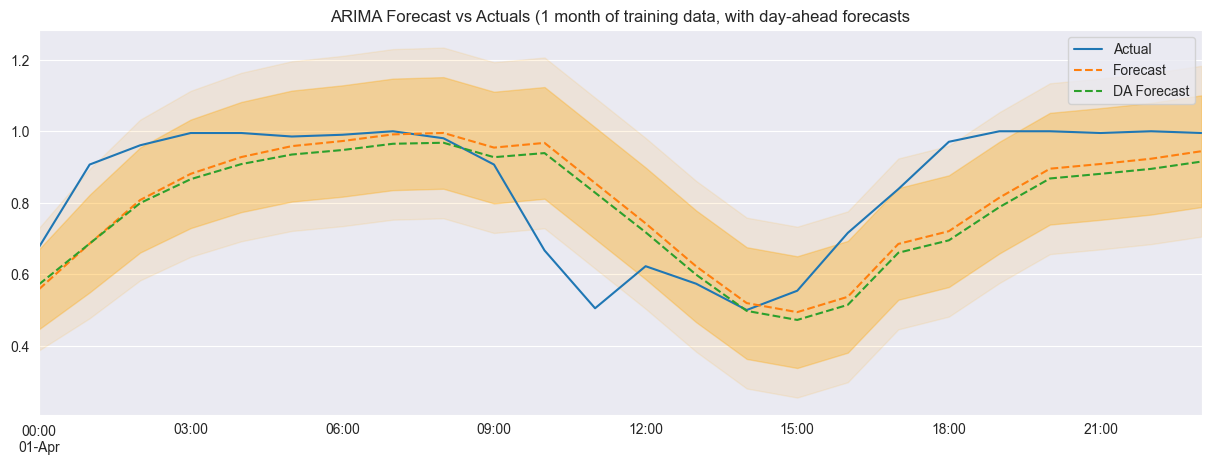

In [30]:
results = evaluate_model(train_power, model_fit, test_power, exog_test)
forecast_info = model_fit.get_forecast(steps=HOURS_PER_DAY, exog=exog_test[:HOURS_PER_DAY])
plot_forecast(test_power[:HOURS_PER_DAY], forecast_info,"ARIMA Forecast vs Actuals (1 month of training data, with day-ahead forecasts",plot_da_forecast=True)

TypeError: 'PredictionResultsWrapper' object is not subscriptable

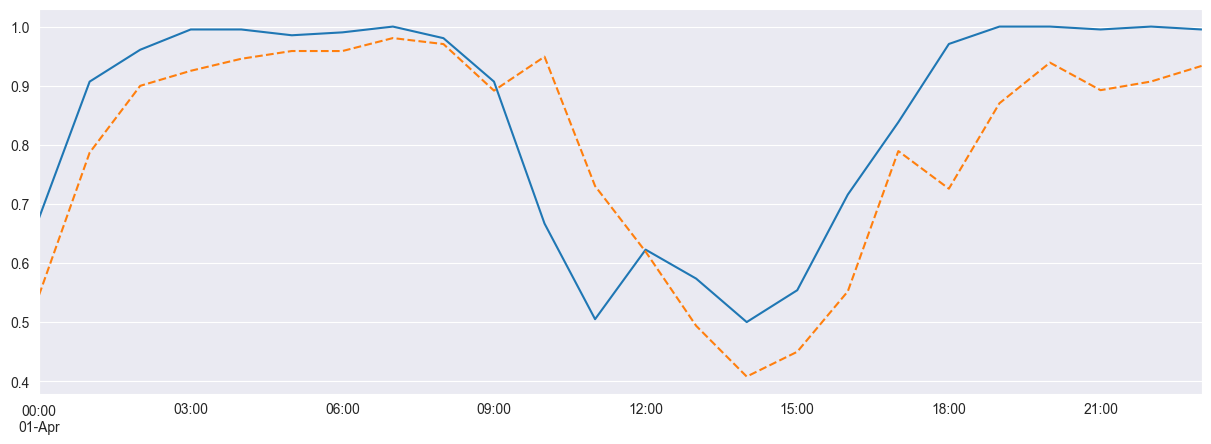

In [73]:
colors = sns.color_palette(n_colors=len(forecasts))

# Plot the first forecast
fig, ax = plt.subplots(figsize=(15, 5))
test_power[:HOURS_PER_DAY].plot(ax=ax, label='Actual')
test_da_power[:HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle='--')
for i, forecast in enumerate(forecasts[:24]):
    pd.Series(forecast[:5]).plot(ax=ax, label=f'Forecast {i} hours',linestyle='--',linewidth=2,color=colors[i])
    # Add a dot for the first hour forecast
    pd.Series(forecast.iloc[0], index=[forecast.index[0]]).plot(ax=ax, marker='o', markersize=5, color=colors[i])
ax.set_title('Wind Speed Forecast vs Actuals')
ax.legend()
plt.show()

## Forecasts generation

In [29]:
day_to_forecast = '01-31-2021'

# Train a model on the last month of data
train_power = power.loc[power.index < day_to_forecast]
train_power = train_power[len(train_power)-1*HOURS_PER_MONTH:]
train_da_power = df['production_FC'].loc[df.index < day_to_forecast]
train_da_power = train_da_power[len(train_da_power)-1*HOURS_PER_MONTH:]

test_power = power.loc[power.index >= day_to_forecast][:HOURS_PER_MONTH]
test_da_power = df['production_FC'].loc[df.index >= day_to_forecast][:HOURS_PER_MONTH]

display(train_power)

2021-01-01 00:00:00    0.995098
2021-01-01 01:00:00    1.000000
2021-01-01 02:00:00    1.000000
2021-01-01 03:00:00    0.995098
2021-01-01 04:00:00    1.000000
                         ...   
2021-01-30 19:00:00    0.990196
2021-01-30 20:00:00    0.995098
2021-01-30 21:00:00    0.990196
2021-01-30 22:00:00    0.990196
2021-01-30 23:00:00    0.960784
Freq: h, Name: production_RE, Length: 720, dtype: float64

In [26]:
model = SARIMAX(train_power, order=(3,0,0),exog=train_da_power,freq='h')

model_fit = model.fit(maxiter=300)

# Generate the rolling forecast for the next month and save the forecasts in a DataFrame
forecasts = pd.DataFrame(columns=[f'FC_{i}h' for i in range(1,25)], index=test_power[:HOURS_PER_MONTH].index)
for i in range(HOURS_PER_MONTH+1):
    forecast_info = model_fit.get_forecast(steps=HOURS_PER_DAY, exog=test_da_power[i:i+HOURS_PER_DAY])
    if i != 0:
        forecasts.iloc[i-1] = forecast_info.predicted_mean.values
    model_fit = model_fit.append(test_power[i:i+1],exog=test_da_power[i:i+1])
display(forecasts)

,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01 19:00:00,0.020358,0.041494,0.023066,0.023809,0.027832,0.029017,0.061179,0.040581,0.092577,0.118436,...,0.072196,0.032888,0.067775,0.030846,0.039423,0.029657,0.095224,0.126952,0.163635,0.127305
2021-03-01 20:00:00,0.040713,0.022372,0.023136,0.027163,0.028358,0.060532,0.039945,0.091952,0.117822,0.074694,...,0.032334,0.06723,0.03031,0.038897,0.029139,0.094715,0.126452,0.163143,0.126822,0.142613
2021-03-01 21:00:00,0.02592,0.026286,0.030219,0.031394,0.063523,0.042882,0.094839,0.12066,0.077483,0.061502,...,0.069747,0.032784,0.041329,0.03153,0.097065,0.128762,0.165414,0.129054,0.144808,0.287747
2021-03-01 22:00:00,0.065684,0.065194,0.065324,0.097235,0.076089,0.127448,0.152706,0.108988,0.092472,0.059353,...,0.060728,0.068798,0.058532,0.123608,0.154855,0.191063,0.154267,0.169592,0.312111,0.343142


In [30]:
model = SARIMAX(train_power, order=(3,0,0),exog=train_da_power,freq='h')

model_fit = model.fit(maxiter=300)

evaluate_model(train_power, model_fit, test_power, test_da_power)

Evaluation time: 20.190388917922974
Train set length: 720
Test set length: 720
Evaluation metrics:


,Hours Ahead,RMSE,MAE
0,1,0.055657,0.055657
1,2,0.074230,0.068573
2,4,0.097846,0.086315
3,6,0.114132,0.099098
4,12,0.148637,0.127128
5,24,0.184403,0.156521


,Hours Ahead,RMSE,MAE
0,1,0.055657,0.055657
1,2,0.074230,0.068573
2,4,0.097846,0.086315
3,6,0.114132,0.099098
4,12,0.148637,0.127128
5,24,0.184403,0.156521


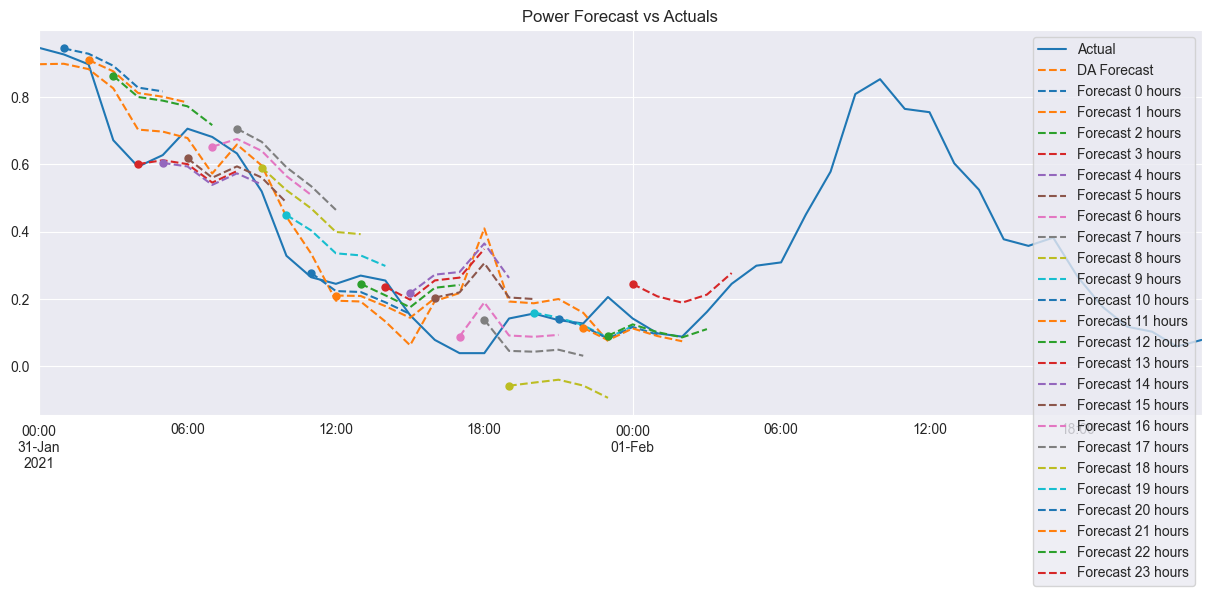

In [36]:
color_pal = sns.color_palette(n_colors=24)

# Plot the first forecast
fig, ax = plt.subplots(figsize=(15, 5))
power[HOURS_PER_MONTH:HOURS_PER_MONTH+2*HOURS_PER_DAY].plot(ax=ax, label='Actual')
df['production_FC'][HOURS_PER_MONTH:HOURS_PER_MONTH+HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle='--')
for i in range(24):
    pd.Series(forecasts.iloc[i].values[:5], forecasts[i+1:i+6].index).plot(ax=ax, label=f'Forecast {i} hours',linestyle='--',color=color_pal[i])
    pd.Series(forecasts.iloc[i].values[0], index=forecasts[i+1:i+2].index).plot(ax=ax, marker='o', markersize=5, color=color_pal[i])
ax.set_title('Power Forecast vs Actuals')
ax.legend()
plt.show()

In [42]:
# Loop over the 2 years of data to generate the forecasts, retrain the model every month
train_power = power
train_da_power = df['production_FC']
forecasts = pd.DataFrame(columns=[f'FC_{i}h' for i in range(1,25)], index=power.index[HOURS_PER_MONTH:])
display(forecasts)
for k in range(24):
    train_power = power[k*HOURS_PER_MONTH:(k+1)*HOURS_PER_MONTH]
    train_da_power = df['production_FC'][k*HOURS_PER_MONTH:(k+1)*HOURS_PER_MONTH]
    
    test_power = power[(k+1)*HOURS_PER_MONTH:(k+3)*HOURS_PER_MONTH]
    test_da_power = df['production_FC'][(k+1)*HOURS_PER_MONTH:(k+3)*HOURS_PER_MONTH]

    model = SARIMAX(train_power, order=(3,0,0),exog=train_da_power,freq='h')
    
    model_fit = model.fit(maxiter=300)
    
    for i in range(HOURS_PER_MONTH+1):
        forecast_info = model_fit.get_forecast(steps=HOURS_PER_DAY, exog=test_da_power[i:i+HOURS_PER_DAY])
        # print(forecast_info.predicted_mean.values)
        if i != 0:
            forecasts.iloc[k * HOURS_PER_MONTH + i-1] = forecast_info.predicted_mean.values
        model_fit = model_fit.append(test_power[i:i+1],exog=test_da_power[i:i+1])
    display(forecasts)
display(forecasts)  

,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,0.660315,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,0.58813,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,0.506595,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,0.344278,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,0.306673,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: Provided exogenous values are not of the appropriate shape. Required (24, 1), got (23,).

In [54]:
# Remove last 24 hours of forecasts
forecasts = forecasts.iloc[:-24]
forecasts = forecasts.clip(lower=0,upper=10)


,production_RE,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-31 00:00:00,0.946078,0.944343,0.928508,0.892814,0.828043,0.816706,0.799553,0.74312,0.774245,0.737732,...,0.448405,0.501246,0.505059,0.585897,0.479943,0.470881,0.470151,0.445021,0.400177,0.429373
2021-01-31 01:00:00,0.926471,0.909883,0.876279,0.812002,0.800768,0.783854,0.727704,0.759095,0.722837,0.645673,...,0.488035,0.492073,0.573131,0.467394,0.458546,0.458025,0.433101,0.38846,0.417855,0.390158
2021-01-31 02:00:00,0.897059,0.862915,0.800139,0.789259,0.772419,0.71644,0.748033,0.711967,0.634986,0.577625,...,0.482594,0.563814,0.458235,0.449542,0.449175,0.424401,0.379907,0.409448,0.381894,0.361544
2021-01-31 03:00:00,0.671569,0.600734,0.612237,0.60069,0.545812,0.579962,0.546918,0.472787,0.418167,0.349841,...,0.422379,0.319203,0.312874,0.314828,0.292338,0.250088,0.281834,0.256449,0.23823,0.260127
2021-01-31 04:00:00,0.593137,0.604321,0.593662,0.538994,0.573189,0.540246,0.466235,0.411728,0.343511,0.338055,...,0.313589,0.307354,0.309403,0.287004,0.244845,0.27668,0.251383,0.23325,0.255231,0.31842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 19:00:00,NaN,0.196954,0.187701,0.156854,0.173426,0.174293,0.219507,0.167123,0.140299,0.127326,...,0.110652,0.129683,0.111171,0.127581,0.194558,0.245438,0.255582,0.348783,0.39157,0.391301
2022-12-29 20:00:00,NaN,0.176381,0.146515,0.163446,0.164497,0.20992,0.157756,0.131145,0.118381,0.11008,...,0.122066,0.103727,0.120306,0.187448,0.238489,0.248791,0.342146,0.385085,0.384963,0.393348
2022-12-29 21:00:00,NaN,0.084264,0.106583,0.109614,0.156045,0.105032,0.079631,0.068042,0.060884,0.153858,...,0.061837,0.079368,0.147439,0.199388,0.210578,0.304801,0.348587,0.349294,0.35849,0.357707
2022-12-29 22:00:00,NaN,0.038056,0.047018,0.095629,0.045725,0.021592,0.011334,0.00547,0.099702,0.046993,...,0.033254,0.102372,0.155345,0.167535,0.262735,0.307477,0.309117,0.319225,0.319334,0.279512


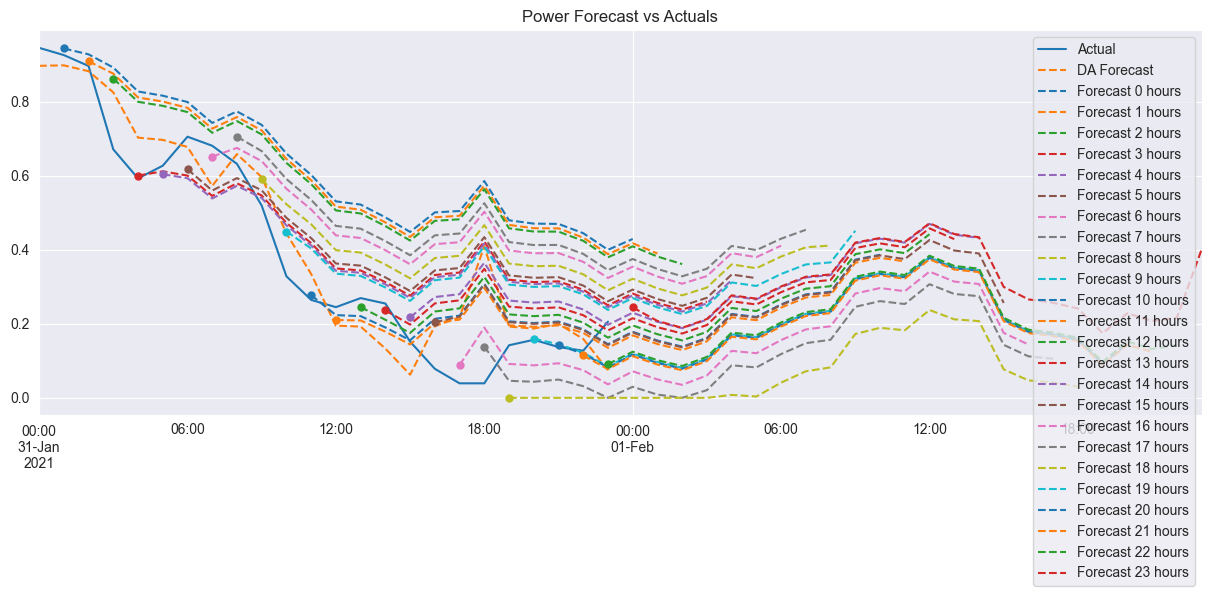

In [55]:
color_pal = sns.color_palette(n_colors=24)

# Plot the first forecast
fig, ax = plt.subplots(figsize=(15, 5))
power[HOURS_PER_MONTH:HOURS_PER_MONTH+HOURS_PER_DAY].plot(ax=ax, label='Actual')
df['production_FC'][HOURS_PER_MONTH:HOURS_PER_MONTH+HOURS_PER_DAY].plot(ax=ax, label='DA Forecast',linestyle='--')
display(pd.concat([power[HOURS_PER_MONTH:HOURS_PER_MONTH+HOURS_PER_DAY],forecasts],axis=1))
for i in range(24):
    pd.Series(forecasts.iloc[i].values, forecasts[i+1:i+1+HOURS_PER_DAY].index).plot(ax=ax, label=f'Forecast {i} hours',linestyle='--',color=color_pal[i])
    pd.Series(forecasts.iloc[i].values[0], index=forecasts[i+1:i+2].index).plot(ax=ax, marker='o', markersize=5, color=color_pal[i])
ax.set_title('Power Forecast vs Actuals')
ax.legend()
plt.show()

In [56]:
# Save the forecasts to a CSV file
forecasts.to_csv('rolling_forecasts_2019_2020.csv')